# Gray-scott Reaction-diffusion

This notebook provides an implementation of the gray-scott reaction diffusion model implemented with finite-differences (not automatic differentiation).

To demonstrate a generative PINN on a problem that admits multiple solutions, we omit the initial condition and
instead consider stationary solutions, which are known to exist for some parameters $\alpha$ and $\beta$.
We show the result of searching for diverse solutions to an under-determined Gray-Scott system. It is a generative PINN producing Turing patterns that morph during latent space interpolation of a neural network conditioned on a latent code.

More details on this example, can be found in [our paper](https://arxiv.org/abs/2402.14009), Sections 4.3 and A.6.

### Imports and setup

In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange

import sys
sys.path.append('..')

from models.NN import encode, GeneralNet# GeneralNetSIREN, GeneralNetPosEnc
from torch.func import vmap, grad, jacrev, jacfwd, functional_call
import torch.nn.functional as F

torch.manual_seed(0)

## Set the device
# device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device = 'cuda:4'
torch.set_default_device(device)

## Model definitions

We use [SIREN's](https://arxiv.org/abs/2006.09661) and a DualNet class to model the two fields $u$ and $v$ of the two substances that mix. For more details, check [our paper](https://arxiv.org/abs/2006.09661), Section 4.3).

In [47]:
from torch import nn

from models.siren import SIREN
class PosEncSIREN(SIREN):
    """Wrapper around SIREN"""
    def __init__(self, ks, w0=1.0, w0_initial=30.0, initializer='siren', c=6, N_posenc=0):
        in_features = ks[0]
        layers = ks[1:-1]
        out_features = ks[-1]
        # if N_posenc>0: w0_initial = 1.0 ## with manual posenc, there is no need to treat SIRENs first layer differently  
        SIREN.__init__(self, layers, in_features, out_features, w0, w0_initial, initializer=initializer, c=c)
        self.ks = ks
        self.N_posenc = N_posenc
    def forward(self, x, z):
        if self.N_posenc:
            x = encode(x, N=self.N_posenc) ## positional encoding
        x = torch.hstack([x, z]) ## stack with latent code
        return torch.sigmoid(self.network(x))

class DualNet(nn.Module):
    """A wrapper to treat two NN models as one."""
    def __init__(self, models):
        super(DualNet, self).__init__()
        self.models = nn.ModuleList(models)
    def forward(self, x, z):
        """Both models have same inputs and a single output each. Forward the inputs to each and stack the outputs. """
        return torch.stack([model(x, z) for model in self.models], dim=-1)

In [48]:
w0_initial = 4.0
nx = 2
ny = 2

def init(use_two_models=True, nz=0):
    """
    NOTE: the positional encoding is used to achieve periodic BCs
    """
    assert use_two_models in [False, True]
    ## Critical: w0_initial
    N_posenc = 1 ## 1 is for periodic BC
    enc_dim = 2*nx*N_posenc
    if use_two_models:
        model = DualNet([PosEncSIREN(ks=[enc_dim+nz, 256, 128, 1], N_posenc=N_posenc, w0_initial=w0_initial) for _ in range(2)])
    else:
        model = PosEncSIREN(ks=[enc_dim+nz, 256, 256, 2], N_posenc=N_posenc, w0_initial=w0_initial)
    params = dict(model.named_parameters())
    return model

model = init()

## Differential operators

We define the differential operators described in [our paper](https://arxiv.org/abs/2006.09661), Equation (5).

In [49]:
## Define differential operators via finite differences

def laplacian_conv(input_tensor, dx0, dx1):
    """
    Discrete Laplacian on a grid using convolution and circular padding.
    input_tensor: [bz, N0, N1]"""

    # Define a 3x3 Laplacian filter for 2D grids
    laplacian_filter = torch.tensor([[0,  1, 0],
                                     [1, -4, 1],
                                     [0,  1, 0]], dtype=torch.float32)

    ## Add a channel dimension for compatibility with conv2d
    laplacian_filter = laplacian_filter.view(1, 1, 3, 3)

    ## Apply circular padding to the input tensor and add a channel dimension
    input_tensor_padded = F.pad(input_tensor, (1, 1, 1, 1), mode='circular').unsqueeze(1)

    ## Apply 2D convolution with the Laplacian filter
    laplacian_result = F.conv2d(input_tensor_padded, laplacian_filter)

    ## Correctly scaled FD Laplacian is the ratio to the discretization size
    laplacian_result /= dx0*dx1

    ## Remove the channel dimension
    return laplacian_result.squeeze(1)


def gradient_conv(input_tensor, dx0, dx1):
    """Discrete gradient on a grid using convolution and circular padding.
    input_tensor: [bz, N0, N1]"""

    ## Define Sobel filters for computing partial derivatives
    sobel_x_filter = torch.tensor([[-1, 0, 1],
                                   [-2, 0, 2],
                                   [-1, 0, 1]], dtype=torch.float32)
    sobel_y_filter = sobel_x_filter.T

    ## Add a batch and channel dimension for compatibility with conv2d
    sobel_x_filter = sobel_x_filter.view(1, 1, 3, 3)
    sobel_y_filter = sobel_y_filter.view(1, 1, 3, 3)

    ## Apply circular padding to the input tensor and add a channel dimension
    input_tensor_padded = F.pad(input_tensor, (1, 1, 1, 1), mode='circular').unsqueeze(1)

    ## Apply 2D convolution with Sobel filters for x and y directions
    gradient_x = F.conv2d(input_tensor_padded, sobel_x_filter)
    gradient_y = F.conv2d(input_tensor_padded, sobel_y_filter)

    # Correctly scaled FD gradient is the ratio to the discretization size
    # 2h for central difference and 4 for normalizing the smoothing along the other dimension
    gradient_x /= 2*dx0*4
    gradient_y /= 2*dx1*4

    ## Remove the channel dimension
    return gradient_x.squeeze(1), gradient_y.squeeze(1)

#### Some helper functions

Two helper functions for plotting (get_domain_grid) and batch-wise concatenation of latent tensor z to input coordinates x.

In [50]:
def get_domain_grid(bounds, N0, N1):
    ## Meshgrid the domain
    x0s, dx0 = np.linspace(bounds[0], bounds[1], N0, endpoint=False, retstep=True)
    x1s, dx1 = np.linspace(bounds[2], bounds[3], N1, endpoint=False, retstep=True)
    X0, X1 = np.meshgrid(x0s, x1s)
    xs = np.vstack([X0.ravel(), X1.ravel()]).T
    xs = torch.tensor(xs).float()
    return xs, X0, X1, dx0, dx1

def tensor_product_xz(x, z):
    """
    Generate correct inputs for bx different xs and bz different zs.
    For each z we want to evaluate it at all xs and vice versa, so we need a tensor product between the rows of the two vectors.
    x: [bx, nx]
    z: [bz, nz]
    returns: [bx*bz, nx+nz]
    """
    z_tp = z.repeat_interleave(len(x), 0)
    x_tp = x.repeat(len(z), 1)
    # xz = torch.hstack([x_rep, z_rep])
    return x_tp, z_tp

#### Diversity

Optionally, one can apply an explicit diversity loss. This is commented out for now, but you can play around with this setting.

In [51]:
def pairwise_dist_fields(y):
    """
    y: [num_fields, num_points, 2] tensor
    pairwise_dist[i, j] contains the distance between fields i and j
    """
    pairwise_dist = (y.unsqueeze(0) - y.unsqueeze(1)).norm(dim=-1).mean(-1)
    return pairwise_dist

def loss_diversity(y):
    """
    Returns the diversity loss.
    Compute all the pairwise distances.
    For every field, take the distance to the closest neighbour.
    Exponentiate all the distances for concavity/uniformity.
    Take mean of those.
    Square to be same order as constraints.
    y: [num_fields, num_points, 2] tensor
    """
    ## Compute pairwise distances
    distances = pairwise_dist_fields(y)
    ## Create a mask to exclude diagonal elements
    distances = distances.masked_fill(torch.eye(distances.size(0), dtype=torch.bool), float('inf'))
    ## Find the minimum distance for each point
    closest_dists, closest_inds = distances.min(dim=1)

    ## NOTE: we need .sqrt() or in general raising to some p<1, to prevent one distance from taking over the loss.
    ## This is analogous to a uniform distribution maximizing entropy.
    return -(closest_dists.sqrt()).mean().square()

## Training loop

We define certain helper variables and lambda-functions for the main training loop. Additional description of parameters and hyperparameters can be found in [our paper](https://arxiv.org/abs/2006.09661), Appendix A.6. Also, important hyperparameters as the feed- and kill-rates Fr and Kr are mentioned there.

F=0.0280, K=0.0570, deviation from bifurcation line=9.00e-04


1.36e-02, -7.63e-01, 0.00e+00:   0%|          | 0/2000 [00:00<?, ?it/s]

8.23e-06, -9.85e-01, 0.00e+00: 100%|██████████| 2000/2000 [00:22<00:00, 89.70it/s]


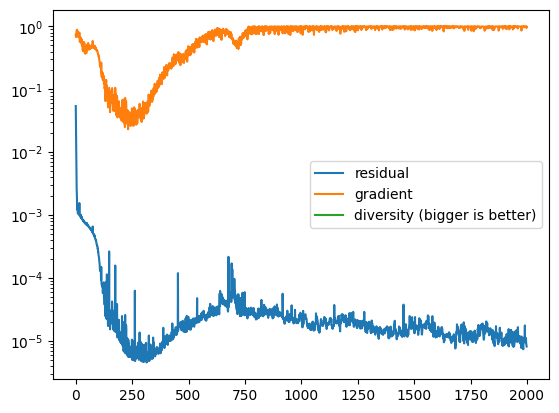

In [52]:
nz = 1
model = init(use_two_models=True, nz=nz)

bounds = (0, 1, 0, 1) ## [0,1]^2 domain
N = 64
N0, N1 = N, N ## number of points in two spatial dimensions


## Diffusion
D1_, D2_ = .1, .05 # these are taken from gray_scott.ipynb grid solver
D1 = D1_ / (64*64) # scale to account for correct Laplacian
D2 = D2_ / (64*64) # scale to account for correct Laplacian

## Feed/kill rates
Fr, Kr = 0.028, 0.057 ## WORMS
# Fr, Kr = 0.102, 0.055 ## type rho: long patterns?
bifurcation_K = lambda Fr : -Fr + .5*Fr**.5 ## compute the exact pair
bifurcation_residual = lambda Fr, Kr : 4*(Fr+Kr)**2 - Fr
# Kr = bifurcation_K(Fr) ## get the exact kill rate to stay on the bifurcation line
print(f"F={Fr:.4f}, K={Kr:.4f}, deviation from bifurcation line={bifurcation_residual(Fr, Kr):.2e}")


bz = 10 ## Batch size
move_grid = True

## Precompute the grid
x, _, _, dx0, dx1 = get_domain_grid(bounds, N0, N1)


## Softclip instead of clip avoids oscillations in the loss, but hard clip still converges to smaller residuals
use_softclip = False
w_grad = 1e-4
if use_softclip:
    softplus = nn.Softplus(beta=10) # higher beta approaches hard clip in the limit
    softclip = lambda x, max_ : -softplus(-x + max_) + max_
    w_grad = 1e-2 # need to weight gradients more with softclip, otherwise it starts to converge toward trivial solution

## Log losses
loss_over_iters = {}
loss_over_iters['obj'] = {}
loss_over_iters['grad'] = {}
loss_over_iters['div'] = {}

# Optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-2)

## Train
for i in (pbar := trange(2000)):
    # if i==1000: opt = torch.optim.Adam(model.parameters(), lr=1e-3)  ## sometimes we can reinit optimizer for much better convergence. Probably escapes some bad optimum
    opt.zero_grad()

    ## Sample random latent
    z = torch.randn(bz, nz)
    
    if move_grid: ## Move the grid every iteration
        x_ = x + torch.rand(1,1)*(1/N)
        x_tp, z_tp = tensor_product_xz(x_, z) ## [bz*bx, nx], [bz*bx, nz]

    ys = model(x_tp, z_tp).reshape(len(z), len(x), ny)
    y0, y1 = ys[...,0], ys[...,1]
    ## First bz entries now correspond to all xs of the first latent code and so on
    
    ### FINITE DIFFERENCES
    ## Reshape to grid so we can apply convolution
    Y0, Y1 = y0.reshape(len(z), N0, N1), y1.reshape(len(z), N0, N1)

    ## LAPLACIANS
    Y0_lap = laplacian_conv(Y0, dx0, dx1)
    Y1_lap = laplacian_conv(Y1, dx0, dx1)
    
    ## Reshape back to vector
    y0_lap = Y0_lap.reshape(len(z),-1)
    y1_lap = Y1_lap.reshape(len(z),-1)

    ## GRADIENTS
    Y0_x0, Y0_x1 = gradient_conv(Y0, dx0, dx1)
    Y1_x0, Y1_x1 = gradient_conv(Y1, dx0, dx1)

    y0_grad_norm = (Y0_x0.square() + Y0_x1.square()).mean()
    y1_grad_norm = (Y1_x0.square() + Y1_x1.square()).mean()
    grad_norms = (y0_grad_norm+y1_grad_norm)
    grad_norms /= 64 ## hyperparam. Properly normalizing grads after convolution makes them 8 times larger. So, here, 8^2=64 smaller.


    ## OBJECTIVE ##
    y011 = y0*y1*y1 ## reaction rate u*v*v
    res1_field = -y011 + Fr*(1-y0)  + D1*y0_lap
    res2_field =  y011 - (Fr+Kr)*y1 + D2*y1_lap
    loss_obj = (res1_field.square() + res2_field.square()).mean()

    ## MAGNITUDE ##
    ## Don't allow constant solutions, since we want the bifurcations
    if use_softclip:
        loss_grad = -softclip(grad_norms, 1) ## gradient norm
    else:
        loss_grad = -torch.clip(grad_norms, max=1) ## gradient norm

    ## DIVERSITY ##
    # loss_div0 = loss_diversity(y0)
    # loss_div1 = loss_diversity(y1)
    # loss_div = loss_div0 + loss_div1
    loss_div = torch.tensor([0.0])
    
    ## OPTIMIZE ##
    loss = loss_obj + w_grad*loss_grad + 1e-7*loss_div
    loss.backward()
    opt.step()

    ## LOG ##
    pbar.set_description(f"{loss_obj.item():.2e}, {loss_grad.item():.2e}, {loss_div.item():.2e}")
    loss_over_iters['obj'][i] =  loss_obj.item()
    loss_over_iters['grad'][i] = -loss_grad.item()
    loss_over_iters['div'][i] = -loss_div.item()


plt.plot(list(loss_over_iters['obj'].keys()), list(loss_over_iters['obj'].values()), label='residual')
plt.plot(list(loss_over_iters['grad'].keys()), list(loss_over_iters['grad'].values()), label='gradient')
plt.plot(list(loss_over_iters['div'].keys()), list(loss_over_iters['div'].values()), label='diversity (bigger is better)')
plt.semilogy()
plt.legend()
plt.show()

### Plotting the result
We visualize the result by sampling a grid in the domain.

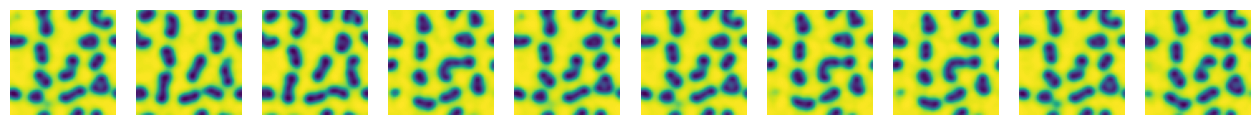

In [53]:
x, X0, X1, dx0, dx1 = get_domain_grid(bounds, N0, N1)
z = torch.randn(10, nz) ## [bz, nz]
x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]


with torch.no_grad():
    ys = model(x_tp, z_tp).reshape(len(z), len(x), ny).squeeze(0)
    Y0, Y1 = ys[...,0].reshape(bz,*X0.shape), ys[...,1].reshape(bz,*X0.shape)


fig, axs = plt.subplots(1, len(z), figsize=(16,2))
for i in range(bz):
    ax = axs[i]
    im = ax.imshow(Y0[i].cpu().detach(), origin='lower')
    ax.axis('scaled')
    ax.axis('off')
plt.show()

### Sanity check for convergence

The following cell is a sanity check. If the NN is too expressive, the higher resolution samples will be very noisy and the field will be invalid inbetween the training points.

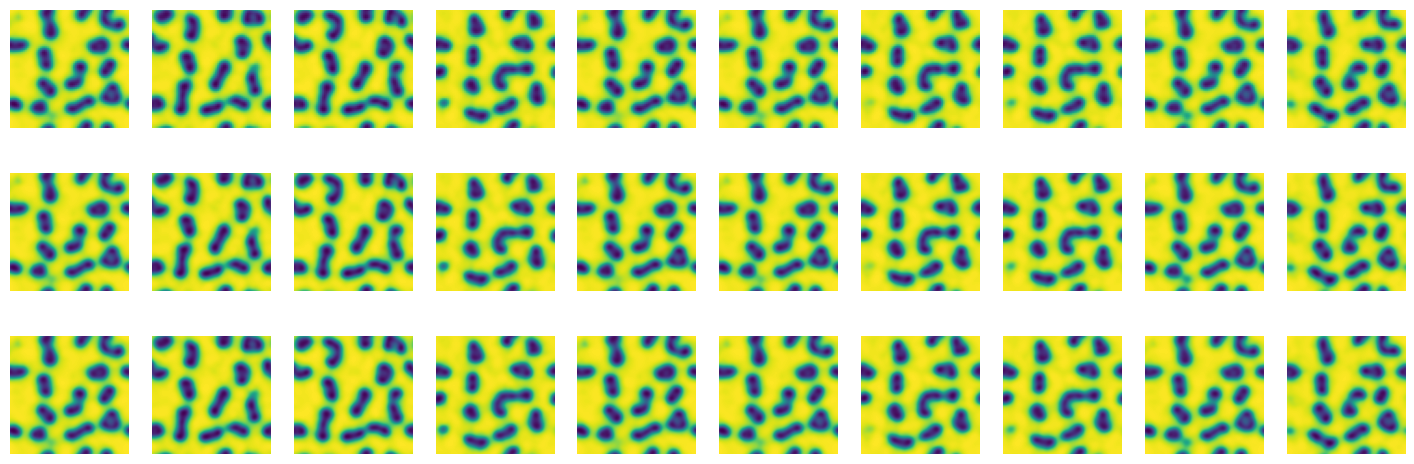

In [54]:
resolutions = [64, 128, 256]

fig, axs = plt.subplots(3, bz, figsize=(18, 6))

for i, N in enumerate(resolutions):
    x, X0, X1, _, _ = get_domain_grid(bounds, N, N)
    x_tp, z_tp = tensor_product_xz(x, z) ## [bz*bx, nx], [bz*bx, nz]

    with torch.no_grad():
        ys = model(x_tp, z_tp).reshape(len(z), len(x), ny).squeeze(0)
        Y0, Y1 = ys[...,0].reshape(bz,*X0.shape), ys[...,1].reshape(bz,*X0.shape)

    for j in range(bz):
        ax = axs[i, j]
        im = ax.imshow(Y0[j].cpu().detach(), origin='lower')
        ax.axis('scaled')
        ax.axis('off')
    
plt.show()